<a href="https://colab.research.google.com/github/Bhaktaraj-Pooja/ML-Project/blob/main/DG_Tom_and_Jerry_29052021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
# Importing Libraries 


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2 
from tqdm import tqdm

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
      #for filename in filenames:
       #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [196]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Mounted at /content/drive


In [197]:
traindf=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train.csv')
print(traindf.shape)
testdf=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test.csv')
print(testdf.shape)

(297, 2)
(179, 1)


In [198]:
traindf.head()

,Frame_ID,Emotion
0,frame1.jpg,happy
1,frame2.jpg,surprised
2,frame3.jpg,surprised
3,frame4.jpg,angry
4,frame5.jpg,surprised


In [199]:
## Create Frames For Train video 
'''
import cv2
vidcap = cv2.VideoCapture('/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train Tom and jerry.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train_frame/frame"+str(count)+".jpg", image) # save frame as JPG file
    return hasFrames,image
train_images =[]
IMAGE_SIZE = (150,150)
sec = 1
frameRate = 1 #//it will capture image in each 0.5 second
count=1
success,image = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
'''

'\nimport cv2\nvidcap = cv2.VideoCapture(\'/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train Tom and jerry.mp4\')\n\ndef getFrame(sec):\n    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)\n    hasFrames,image = vidcap.read()\n    if hasFrames:\n        cv2.imwrite("/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train_frame/frame"+str(count)+".jpg", image) # save frame as JPG file\n    return hasFrames,image\ntrain_images =[]\nIMAGE_SIZE = (150,150)\nsec = 1\nframeRate = 1 #//it will capture image in each 0.5 second\ncount=1\nsuccess,image = getFrame(sec)\nwhile success:\n    count = count + 1\n    sec = sec + frameRate\n    sec = round(sec, 2)\n    success = getFrame(sec)\n'

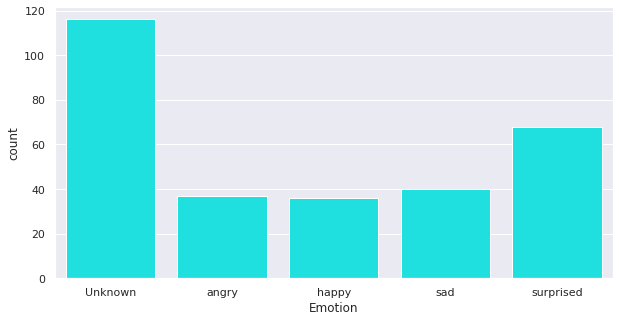

In [200]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', data=traindf,
                   order=list(traindf['Emotion'].value_counts().sort_index().index) ,
                   color='cyan')

In [201]:
traindf.loc[traindf['Frame_ID'] == 'frame0.jpg']['Emotion']
class_names =np.unique(traindf['Emotion'])
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_names_label)

{'Unknown': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'surprised': 4}


In [202]:
## Create Frames For Test video
'''
import cv2
vidcap = cv2.VideoCapture('/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test Tom and Jerry.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test_frame/""test"+str(count)+".jpg", image) # save frame as JPG file
    return hasFrames,image
test_images =[]
IMAGE_SIZE = (150,150)
sec = 1
frameRate = 1 #//it will capture image in each 0.5 second
count=1
success,image = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
'''    

'\nimport cv2\nvidcap = cv2.VideoCapture(\'/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test Tom and Jerry.mp4\')\n\ndef getFrame(sec):\n    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)\n    hasFrames,image = vidcap.read()\n    if hasFrames:\n        cv2.imwrite("/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test_frame/""test"+str(count)+".jpg", image) # save frame as JPG file\n    return hasFrames,image\ntest_images =[]\nIMAGE_SIZE = (150,150)\nsec = 1\nframeRate = 1 #//it will capture image in each 0.5 second\ncount=1\nsuccess,image = getFrame(sec)\nwhile success:\n    count = count + 1\n    sec = sec + frameRate\n    sec = round(sec, 2)\n    success = getFrame(sec)\n'

In [203]:
## Read Train Frames 

IMAGE_SIZE = (256, 256)
dataset = '/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Train_frame'
output = []
train_images = []
train_labels = []
for files in tqdm(os.listdir(dataset)):
    try:
        label=class_names_label[traindf.loc[traindf['Frame_ID'] == files]['Emotion'].values[0]]
    except:
        #do nothing
        a=1
    img_path=os.path.join(dataset, files)
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    train_images.append(image)
    train_labels.append(label)

100%|██████████| 297/297 [00:04<00:00, 61.72it/s]


In [204]:
train_images = np.array(train_images, dtype = 'float32')/255
train_labels = np.array(train_labels, dtype = 'int32') 

In [205]:
## Read test Frames 
IMAGE_SIZE = (256, 256)
dataset = '/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Test_frame'
output = []
test_images = []
for files in tqdm(os.listdir(dataset)):
    img_path=os.path.join(dataset, files)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    test_images.append(image)
test_images = np.array(test_images, dtype = 'float32')/255

100%|██████████| 179/179 [00:02<00:00, 67.62it/s]


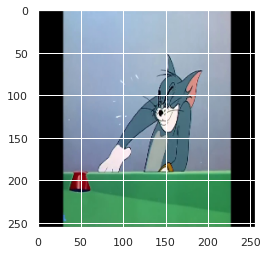

In [206]:
plt.imshow(test_images[25])

In [207]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [208]:
input_shape = x_train.shape[1:]
# Normalize data.
x_train = x_train.astype('float32') 
y_train = y_train.astype('float32') 
print(input_shape)

(256, 256, 3)


In [209]:
print(y_train.shape)
print(y_val.shape)

(207,)
(90,)


In [210]:
print(x_train.shape)
print(x_val.shape)

(207, 256, 256, 3)
(90, 256, 256, 3)


In [211]:
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
    from keras.optimizers import SGD
    from keras.callbacks import TensorBoard

In [ ]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32,(3,3), input_shape = (256,256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#Adding more layers 
classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

#Adding more layers 

classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Step 3 - Flattening
classifier.add(Dropout(0.5))
classifier.add(Flatten())

# Step 4 - Full connection
#classifier.add(Dense(output_dim = 300, activation = 'relu'))
#classifier.add(Dense(output_dim = 100, activation = 'relu'))
#classifier.add(Dense(output_dim = 5, activation = 'softmax'))

classifier.add(Dense(300, activation = 'relu'))
classifier.add(Dense(100, activation = 'relu'))
classifier.add(Dense(5, activation = 'softmax'))

# Compiling the CNN
from keras import optimizers

#o = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#classifier.compile(optimizer = Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
classifier.compile(optimizer = Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

epochs=50
classifier.fit(x_train,
             y_train,
             batch_size=32,
             #nb_epoch=epochs,
             epochs=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 1.5516 - accuracy: 0.3504 - val_loss: 1.6972 - val_accuracy: 0.4000
Epoch 2/50
7/7 [==============================] - 15s 2s/step - loss: 1.5044 - accuracy: 0.4032 - val_loss: 1.3780 - val_accuracy: 0.4444
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 1.3055 - accuracy: 0.4994 - val_loss: 1.3622 - val_accuracy: 0.3778
Epoch 4/50
7/7 [==============================] - 15s 2s/step - loss: 1.2615 - accuracy: 0.5338 - val_loss: 1.3804 - val_accuracy: 0.4333
Epoch 5/50
7/7 [==============================] - 15s 2s/step - loss: 1.2196 - accuracy: 0.5268 - val_loss: 1.2795 - val_accuracy: 0.4444
Epoch 6/50
7/7 [==============================] - 15s 2s/step - loss: 1.0545 - accuracy: 0.5555 - val_loss: 1.2437 - val_accuracy: 0.4667
Epoch 7/50
7/7 [==============================] - 15s 2s/step - loss: 0.9609 - accuracy: 0.6451 - val_loss: 1.2505 - val_accuracy: 0.4444
Epoch 8/50
7/7 [==================

In [ ]:
classifier.summary()

In [ ]:
import pydot
#keras.utils.plot_model(classifier)

In [ ]:
scores = classifier.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
y_test_prob = classifier.predict(test_images)
y_test_prob.round(2)

In [ ]:
y_test_pred = classifier.predict_classes(test_images)
y_test_pred

In [ ]:
elo = np.array(class_names)[y_test_pred]
elo

In [ ]:
f=95
print(plt.imshow(test_images[f]),elo[f])

In [ ]:
type(elo)

In [ ]:
df2 = testdf.assign(Emotion = elo) 

In [ ]:
df2.head()

In [ ]:
df2.to_csv('/content/drive/MyDrive/ColabNotebooks/ToonsProblem/Submission/submission2.csv', header=True, index=False)